<a href="https://colab.research.google.com/github/MevrouwHelderder/Assignments/blob/main/Assignment_Shark_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: 
Take [this dataset](https://www.kaggle.com/felipeesc/shark-attack-dataset). Use all the skills you've learned up until now to answer the following questions as well as possible. 

* What are the most dangerous types of sharks to humans? 
* Are children more likely to be attacked by sharks? 
* Are shark attacks where sharks were provoked more or less dangerous? 
* Are certain activities more likely to result in a shark attack? 

If you feel you can't answer a question based on the dataset alone, feel free to find other datasets and use them in answering the questions.

For each answer you give not only answer the question but also write about the assumptions you made in answering the question. If an assumption or decision possibly created a bias please write about this as well.

# The essentials

In [ ]:
# Importing the essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

%load_ext google.colab.data_table

In [ ]:
# importing the dataframe
path = "/content/drive/MyDrive/attacks.csv"
df = pd.read_csv(path, encoding="ISO-8859-1")

In [ ]:
# Making a copy so to not change the original dataset while modifying the shape
attacks_shape = df.copy(deep=True)

# Preparing the basics of the dataframe

In [ ]:
# Dropping columns.
attacks_shape = attacks_shape.drop(
    columns=[
        "Date",
        "Time",
        "Case Number",
        "Location",
        "Name",
        "Investigator or Source",
        "pdf",
        "href formula",
        "Area",
        "href",
        "Case Number.1",
        "Case Number.2",
        "original order",
        "Unnamed: 22",
        "Unnamed: 23",
    ]
)

In [ ]:
#Checking on the names of the column
list(attacks_shape)

# Renaming columns.
attacks_shape = attacks_shape.rename(
    columns={"Case Number": "Case", "Sex ": "Sex", "Fatal (Y/N)": "Outcome", "Species ": "Species"})

In [ ]:
# Dropping rows that have a null value on all columns except for the column "Case".
# Having only a casenumber made them useless by default.
#
# Making a copy to prevent view vs copy issues later on 


relevant_columns = list(attacks_shape.columns[1:])
attacks_shape = attacks_shape.dropna(subset=relevant_columns, how="all").copy(deep=True)


# Helpers
Below are functions that help during one or more parts of the process.
I realise that the functions that handle the non-default missing values
are not my own: we used them in an earlier exercise.

However, they are useful and it would be dumb to pretend they are my own by changing a tiny bit.

So credit where credit is due, thanks Winc!

In [ ]:
# Functions to help finding non-default missing values:

# Preparing the functions for locating and adjusting the missing values.
def print_separator(sep, num, msg):
    print("\n")
    print(sep * num)
    print(f"{msg}")
    print(sep * num)

# TACTIC A: find unique values
def look_at_unique_values(column):
    unique_values_cutoff = 50
    unique_values = column.unique()
    num_unique_values = len(unique_values)
    if num_unique_values == len(column):
        print(f"Each value in the column is unique (total: {num_unique_values})")
    elif num_unique_values < unique_values_cutoff:
        print(f"Less than {unique_values_cutoff} unique values:")
        try:
            sorted = np.sort(unique_values)
            print("Values are sorted")
            display(list(sorted))
        except:
            print("Could not sort values")
            display(list(unique_values))
    else:
        print(
            f"More than {unique_values_cutoff} unique values (total: {num_unique_values})"
        )

# TACTIC B: look at the edges
def look_at_edges(df, column_name):
    # inner function
    def show_head_and_tail(values):
        num_items_to_slice = 10
        display(list(values)[:num_items_to_slice])
        display(list(values)[-num_items_to_slice:])

    column = df[column_name]
    unique_values = column.unique()
    try:
        sorted = np.sort(unique_values)
        print("Unique values sorted, head and tail:")
        show_head_and_tail(sorted)
    except TypeError as error:
        print(f"Could not sort values: {error}")
        print("..so let's try filtering NULL values and then sorting")
        print("..there could be a black sheep in the null values")
        non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
        sorted = np.sort(non_null_uniques)
        show_head_and_tail(sorted)

# TACTIC C: casting to a type to see if all the values match the needed type
def cast_to_type(column, maybe_type):
    try:
        column.astype(maybe_type)
        print(f"Casting to {maybe_type} was successful")
    except ValueError as error:
        print(f"Could not cast to {maybe_type}: {error}")

# TACTIC D: display the value count of the column
def value_count(column):
    display(column.value_counts(dropna=False))

# FUNCTION TO CHECK THE DATAFRAME FOR ALL FOUR TACTICS
def find_non_default_missing_values(df, column_name, maybe_type):
    long_separator_amount = 80
    short_separator_amount = 40
    # Print the header
    print_separator(
        "*",
        long_separator_amount,
        f'Finding non default missing values for column "{column_name}"',
    )
    print(f'Column "{column_name}" has datatype: {df.dtypes[column_name]}')
    column = df[column_name]
    # A
    print_separator("-", short_separator_amount, "A: Looking at unique values")
    look_at_unique_values(column)
    # B
    print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
    look_at_edges(df, column_name)
    # C
    print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
    cast_to_type(column, maybe_type)
    # D
    print_separator(
        "-",
        short_separator_amount,
        "D: Looking at frequency\nAll default-NULL values will be bunched together as NaN",
    )
    value_count(column)
    print("\n")

# Function to display the default NULL values in the column.
def display_default_null_values(df, column_name):
    nulls = df.loc[df[column_name].isnull()]
    print(f'Number of default null values in "{column_name}": {len(nulls)}')

# Easier to type
nat = np.datetime64("nat")


  

In [ ]:
# Function to change values based on a non-nested dictionary
# ⚠️ Mutates df
def replace_multi(df, col, dict):
    df[col] = df[col].replace(dict)
    
# Function to replace a single values with another single value.
# ⚠️ Mutates df
def replace_one(df, col, old_value, new_value):
  df[col] = df[col].replace({old_value : new_value})

# Function to replace multiple values with one value
# ⚠️ Mutates df
def replace_multi_to_one(df, col, old_list, new_value):
  df[col] = df[col].replace(dict.fromkeys(old_list, new_value))

# Function to replace using regular expressions
# ⚠️ Mutates df
def replace_regex(df, col, old_value, new_value):
  df[col] = df[col].str.replace(old_value, new_value, regex=True)


# Cleaning up the columns
Goal: keep only the data needed.

I do apologise beforehand. I suspect on some columns I did more than needed for this assignment. 

Especially when cleaning up/sorting out the last crumbs. 

I realise they probably have no significant influance and that when time and or money are an issue they probably should have been left as the were or even thrown out, depending on the goal.
But I simply had a blast and it tought me so many new skills that I took the opportunity to learn by doing.

I might also have used one tactic on a column but another on a different column. In between working on the different columns I learned a lot and I also experimented to see what worked better.

And lastly: I realise I have written some functions that could perhaps be combined. However, for now I prefer to leave them since they show the steps I took while cleaning up.

In [ ]:
# Making a copy to work on, to keep track of the changes
attacks_clean = attacks_shape.copy(deep=True)

In [ ]:
# Lowercase all strings and strip whitespace and/or quotationmarks around strings
attacks_clean = attacks_clean.applymap(lambda x: x.lower() if isinstance(x, str) else x)
attacks_clean = attacks_clean.applymap(lambda x: x.strip('" ') if isinstance(x, str) else x)

# Column: Species

In [ ]:
# Checking how everthing looks and what stands out: 
# find_non_default_missing_values(attacks_clean, 'Species', 'string')

In [ ]:
# Extract the species from the string where possible

# if any for of null: change to None
# if empty after stripping whitespace: change to None
# if the word shark is there: return that plus the word before "shark"
# else: return the original plus "check: "

def tidy(x):                                
    if pd.isna(x):                                    
        return None
    elif len(x.strip()) == 0:                         
        return None
    elif "shark" in x:                                
        return re.search(r"(\S+\s*)?shark", x).group()
    else:
        return f"check: {x}"                          


attacks_clean["Species"] = attacks_clean["Species"].apply(tidy)

In [ ]:
# Things we can now safely change to "unconfirmed"
# Values that mention certain words.
# Values that mention no species but mention measurements like 20"] 

no_species = [
    "invalid",
    "unidentified",
    "questionable",
    "possibly",
    "not confirmed",
    "unconfirmed",
    "doubtful",
    "captive",
    "unknown",
    "several",
    "colored",
    "large shark",
    "female shark",
    "grey shark",
    "two shark",
    "the shark",
    "from shark",
    "little shark",
    "larger shark",
    "red shark",
    "young shark",
    "for shark",
    "metre shark",
    "juvenile shark",
    "gray shark",
    "finned shark",
    "small shark"
]

# one or more digits followed by ' or " followed by
# zero or more ] followed by shark, whitespaces optional
inches = r'\d+\s*(["\']{1,})\s*\]*\s*shark'

# string containing two or less letters or digits or -
# followed by shark, whitespaces optional
small_string = r"^[a-z0-9-]{0,2}\s*shark$"

# lb or kg or foot followed by zero or more ] followed by shark, whitespaces optional
measurements = r"(kg|lb|foot)\s*\]*\s*shark"


def tidy_more(x):
    if x is not None and (
        any(word in x for word in no_species)
        or re.search(inches, x)
        or re.search(small_string, x)
        or re.search(measurements, x)
    ):
        return "unconfirmed"
    else:
        return x


attacks_clean["Species"] = attacks_clean["Species"].apply(tidy_more)

In [ ]:
# removing quotation marks and this weird little fellas that look the same but are different:  
def remove_weirdos(x):
    if x is None:
        return None
    else:
        return re.sub(r'["]+', "", x)

attacks_clean["Species"] = attacks_clean["Species"].apply(remove_weirdos)

In [ ]:
# Checking all values that I previously marked as 'check'
mask_species = attacks_clean["Species"].str.contains("check", na=False)
attacks_clean[mask_species]

# Changing to the right species where possible
correct_species = [
    "blue pointer",
    "wobbegong",
    "whaler",
    "hammerhead",
    "porbeagle",
    "whitetip",
    "horn",
]

def correct_checks(x):
    if x is not None and ("check" in x):
        for word in correct_species:
            if word in x:
                return f"{word} shark"
        else:
            return "unconfirmed"
    else:
        return x

attacks_clean["Species"] = attacks_clean["Species"].apply(lambda x: correct_checks(x))


In [ ]:
# Checking last crumbs to clean up:
# Replace a few different writings of the same species

replacing = {"seven-gill shark": "sevengill shark",
        "7-gill shark": "sevengill shark",
        "sevengill  shark": "sevengill shark",
        "black-tipped shark": "blacktip shark",
        "blacktip  shark": "blacktip shark",
        "sand shark": "sandshark",
        "zambesi shark": "zambezi shark"}

replace_multi(attacks_clean, "Species", replacing)

In [ ]:
# attacks_clean["Species"].value_counts().head(50)
# attacks_clean["Species"].value_counts().tail(50)

In [ ]:
# Added later: 
# change everything unconfirmed to None.
# For our questions it makes it cleaner to work with.

replace_one(attacks_clean, "Species", "unconfirmed", None)

# Column: Case

In [ ]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Case", "string")

# There are some duplicate values. 
# Checking what they mean: 

# attacks_clean[attacks_clean.duplicated('Case', keep=False)]

# They might indicatie cases where more then one person was attacked. 
# The columns regarding location and time might help here if needed but since 
# there are few and they seem irrelevant to our questions I will leave them for now

# Column: Type

In [ ]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Type", "string")

In [ ]:
# After working on the questions I realised I could safely change some values to None: 
replace_list = ["boating", "boatomg", "boat", "sea disaster", "invalid", "questionable", np.nan ]
replace_multi_to_one(attacks_clean, "Type", replace_list, None)

In [ ]:
attacks_clean["Type"].value_counts().head(50)
# attacks_clean["Type"].value_counts().tail(50)

unprovoked    4595
provoked       574
Name: Type, dtype: int64

# Column: Activity

In [ ]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Activity", "string")

In [ ]:
# Replacing the null values
replace_activity = {".": None, np.nan: None}
replace_multi(attacks_clean, "Activity", replace_activity)

# Boarding seems to be a substantial part. Combining different spellings of the same value
boarding = ["boogie boarding", "paddle boarding", "body-boarding", "body boarding", "paddle-boarding"]
replace_multi_to_one(attacks_clean, "Activity", boarding, "bodyboarding")

In [ ]:
# Taking the top 60 values as categories and dividing the other values, where possible,
# into those categories.

top_activities = list(attacks_clean["Activity"].value_counts().head(60).index)

def activities_checks(x):
    if x is not None:
      for word in top_activities:
          if word in x:
              return word
      else:
          return x

attacks_clean["Activity"] = attacks_clean["Activity"].apply(lambda x: activities_checks(x))

In [ ]:
# attacks_clean["Activity"].value_counts().head(50)
# attacks_clean["Activity"].value_counts().tail(50)

# Column: Outcome

In [ ]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Outcome", "string")

In [ ]:
# Changing values to corresponding categories
replace_outcome = {"n" : "nonfatal", "y" : "fatal", "m" : "unconfirmed", "2017": "unconfirmed", "unknown": "unconfirmed", np.nan : None}
replace_multi(attacks_clean, "Outcome", replace_outcome)

In [ ]:
# attacks_clean["Outcome"].value_counts().head(50)
# attacks_clean["Outcome"].value_counts().tail(50)

In [ ]:
# Added later: 
# change everything unconfirmed to None.
# For our questions it makes it cleaner to work with.

replace_one(attacks_clean, "Outcome", "unconfirmed", None)

# Column: Age

In [ ]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Age", "string")

In [ ]:
# change NaN to None
replace_age= {np.nan : None, "": None}
replace_multi(attacks_clean, "Age", replace_age)

In [ ]:
# convert non-null values to string
non_null = attacks_clean["Age"].notnull()
attacks_clean.loc[non_null, "Age"] = attacks_clean.loc[non_null, "Age"].astype(str)

In [ ]:
# Sorting into age groups, creating a new column for this

# Sorting ages by range
child = [str(i) for i in range(0, 13)]
adolescent = [str(i) for i in range(13, 18)]
adult = [str(i) for i in range(18, 130)]

# Sorting all the values that describe the age in words
child_words = ["child", "2 to 3 months", "9 months", "18 months", "2½", "both 11", "6½"]
adolescent_words = ["teen", "teens"]
adult_words = ["adult" , "middle-age", "(adult)", "20s", "30s", "40s", "50s", "elderly", "60's", "60s", "mid-20s", "mid-30s", "ca. 33"]

# tackling values that mention multiple ages by splitting into seperate ages
# and sorting into the right group but only if all ages belong to the same group 
def age_groups(age):
    if age is None:
        return age
    else:
        age_list = re.split(r'[,&\s?]|(?:\s*(?:to|or)\s*)', age) 
        age_list = list(filter(None, age_list))  
        if all(word in child for word in age_list) or age in child_words:
            return "child"
        elif all(word in adolescent for word in age_list) or age in adolescent_words:
            return "adolescent"
        elif all(word in adult for word in age_list) or age in adult_words:
            return "adult"
        else:
            return None

attacks_clean.insert(4, "Age_group", attacks_clean["Age"].apply(age_groups))

# Column: Injury

I noticed a lot of injuries were the same but with different spellings.
I sorted them into broader groups.

It could have been sorted even more but I found this to be a good medium.

In [ ]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Injury", "string")

In [ ]:
# change NaN to None
replace_injury= {np.nan : None, "": None}
replace_multi(attacks_clean, "Injury", replace_injury)

In [ ]:
# Removing some words for better sorting, stripping whitespace
removable = r"\bleft\b|\bright\b|\bminor\b|\bsevere\b|\blower\b|\bto dorsum of\b|\bsmall\b"
replace_regex(attacks_clean, "Injury", removable, "no injury")
# stripping whitespace
attacks_clean["Injury"] = attacks_clean["Injury"].str.strip()

# Correcting some words for better sorting
replace_one(attacks_clean, "Injury", "injury", "injuries")

# Replace values that contain "fatal" with just "fatal"
replace_regex(attacks_clean, "Injury", r".*\bfatal\b.*", "fatal")

# Replace values that contain "no injury" with just "no injury"
replace_regex(attacks_clean, "Injury", r".*\bno injury\b.*", "no injury")

In [ ]:
# Combining laceration/lacerated/etc.

# Replace "laceration" with "lacerations"
replace_regex(attacks_clean, "Injury", r"\blaceration\b", "lacerations")
# Replace "lacerated" with "lacerations"
replace_regex(attacks_clean, "Injury", r"\blacerated\b", "lacerations")

# If "lacerations" is present: place it at the front of the string
def move_lacerations_to_front(injury):
    if injury is None:
        return injury
    else: 
      if "lacerations" in injury:
         return "lacerations " + injury.replace("lacerations", "").strip()
      else:
         return injury.strip()

# Apply the function to the "Injury_2" column
attacks_clean["Injury"] = attacks_clean["Injury"].apply(move_lacerations_to_front)

In [ ]:
# Combining injured/injury/etc.

# Replace "injuries" with "injury"
replace_regex(attacks_clean, "Injury", r"\binjuries\b", "injury")
# Replace "injured" with "injury to"
replace_regex(attacks_clean, "Injury", r"\binjured\b", "injury to")

# If "injury to" is present: place it at the front of the string
def move_injury_to_front(injury):
    if injury is None:
        return injury
    else: 
      if "injury to" in injury:
         return "injury to " + injury.replace("injury to", "").strip()
      else:
         return injury.strip()

# Apply the function to the "Injury_2" column
attacks_clean["Injury"] = attacks_clean["Injury"].apply(move_injury_to_front)

In [ ]:
# Remove double whitespaces
replace_regex(attacks_clean, "Injury", r"\s{2,}", " ")

In [ ]:
# Checking how is looks now: 
# attacks_clean["Injury"].value_counts().head(20)
# attacks_clean["Injury"].value_counts().tail(20)

# Column: Sex
probably unnescessary for these questions but I'm curious about the differences

In [ ]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Sex", "string")

In [ ]:
# Changing Nan and the three unspecified ones to None.
replace_sex= [np.nan, "n", "lli", "."]
replace_multi_to_one(attacks_clean, "Sex", replace_sex, None)

# Column: Country

In [ ]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Country", "string")

In [ ]:
# Changing nan to None
replace_one(attacks_clean, "Country", np.nan, None)

# Column: Year

In [ ]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Year", "int64")

In [ ]:
# Change to type string,  stripping the .0 from the right sides
attacks_clean["Year"] = attacks_clean["Year"].astype(str).str.rstrip('.0')

In [ ]:
# Changing to None if there is no complete year available

attacks_clean["Year"] = attacks_clean["Year"].apply(lambda x: None if len(str(x)) < 4 else x)

In [ ]:
# attacks_clean["Year"].value_counts().head(60)
# attacks_clean["Year"].value_counts().tail(60)

# On to the questions!


In [ ]:
# Making a copy to prevent messing up earlier steps: 
shark_attacks = attacks_clean.copy(deep=True)

In [ ]:
shark_attacks

,Year,Type,Country,Activity,Age_group,Sex,Age,Injury,Outcome,Species
0,2018,None,usa,paddling,adult,f,57,no injury,nonfatal,white shark
1,2018,unprovoked,usa,standing,child,f,11,no injury,nonfatal,None
2,2018,None,usa,surfing,adult,m,48,no injury,nonfatal,None
3,2018,unprovoked,australia,surfing,None,m,None,no injury,nonfatal,None
4,2018,provoked,mexico,diving,None,m,None,lacerations to leg & hand shark provoked incident,nonfatal,tiger shark
...,...,...,...,...,...,...,...,...,...,...
6297,None,unprovoked,australia,diving,None,m,None,fatal,fatal,None
6298,None,unprovoked,australia,diving,None,m,None,fatal,fatal,None
6299,None,unprovoked,usa,swimming,None,m,None,fatal,fatal,None
6300,None,unprovoked,panama,None,None,m,None,fatal,fatal,None


# Question 1: What are the most dangerous types of sharks to humans?
**Thoughts**: You could think it is as simply the species that has the highest count of attacks.

**But**: what is the definition of "most dangerous"? 

Is a species that has a lot of non-fatal attacks more dangerous than a species that attacks less but whos attacks are often fatal?

Let's look at the outcome of the attacks. 
Is there a correlation betweet the species that attack the most and the species that have the most fatal attacks?


---





Before I do that I need to know if the groups of results where both the species AND the outcome is confirmed is big enough. 
To do that I will compare that group to the group where only the species is confirmed.

In [ ]:
null_species_count = shark_attacks["Species"].notnull().sum()
null_both_count = (shark_attacks["Species"].notnull() & shark_attacks["Outcome"].notnull()).sum()
difference = null_species_count - null_both_count
print(f"The amount of attacks where the species is confirmed is:  {null_species_count}")
print(f"The amount of attacks where both the species and the outcome are confirmed is:  {null_both_count}")
print(f"There are {difference} attacks where the species is confirmed but the outcome is not ")

The amount of attacks where the species is confirmed is:  1914
The amount of attacks where both the species and the outcome are confirmed is:  1887
There are 27 attacks where the species is confirmed but the outcome is not 


That is a really small difference.
I feel confident that for this question I can work with only the attacks where both the species and the outcome are confirmed. 


---



# Visualising the attacks per species
I want to not only show amount of attacks per species but also the percentage of the attacks that is fatal.

However, there is no use to look at the fatality rate alone. A species that has only one record would get a 100% rate, for example. 

Therefore, I will use it together with the total attack count of the species that are in the top ten of species that have the most attacks on their names.

In [ ]:
# Selecting only the rows where both species and outcome are confirmed: 
question_one_mask = (shark_attacks["Species"].notnull()) & (shark_attacks["Outcome"].notnull())
question_one_df = shark_attacks[question_one_mask]

In [ ]:
# Top ten species when looking at total attacks
total_species = question_one_df["Species"].value_counts()
top_total_species = total_species.sort_values(ascending=False).head(10)

# Fatal attack count per species.
fatal_species = question_one_df.loc[question_one_df["Outcome"] == "fatal", "Species"].value_counts()

# Fatality rate for each species.
fatality_species = (fatal_species / total_species) * 100

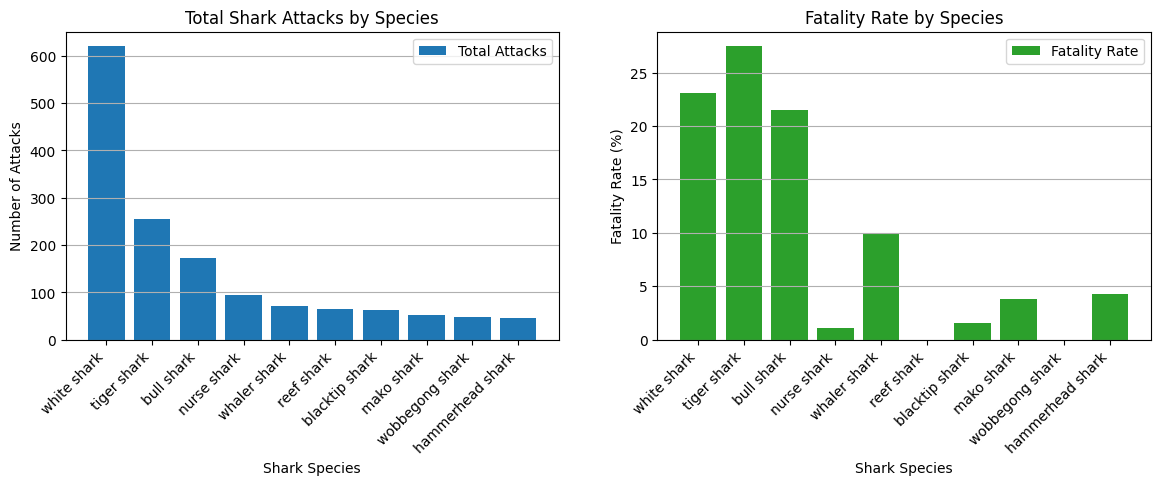

In [ ]:
# Create the figure and the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# X-axis both plots
species2 = top_total_species.index

# Y-axis total attacks
total2 = top_total_species
# Y-axis fatality rate
fatality2 = fatality_species.loc[top_total_species.index] 

# Bars
ax1.bar(species2, total2, label="Total Attacks")
ax2.bar(species2, fatality2, label="Fatality Rate", color="C2")

# Set common cosmetics
for ax in [ax1, ax2]:
    ax.set_xlabel("Shark Species")
    ax.set_xticks(species2)
    ax.set_xticklabels(species2, rotation=45, ha="right")
    ax.grid(axis='y')
    ax.legend()
    
# Set individual cosmetics
ax1.set_ylabel("Number of Attacks")
ax1.set_title("Total Shark Attacks by Species")
ax2.set_ylabel("Fatality Rate (%)")
ax2.set_title("Fatality Rate by Species")
plt.subplots_adjust(wspace=0.2)

plt.show()

# Conclusion: Interesting!

We can see that the white shark is responsible for the most attacks in general and the most attacks with a deadly outcome. Almost twice as much in both categories than the species that comes second: the tiger shark.
That is why I deem the white shark the species that is most dangerous to humans. 

However: we can see that the tiger shark has the highest fatality rate. Higher than the white shark. In other words: it attacks less but its attacks are more dangerous then the attacks of the white shark.

So when it comes to answering the question "What are the most dangerous types of sharks to humans?" my answer is:


The white shark. But if for some reason you are faced with two pools, one containing a white shark and one containing a tiger shark and you are forced to jump into one... You might want to consider joining the white shark and not the tiger shark ;-)


---





# Question 2: Are children more likely to be attacked by sharks?

For this I want to look at how the attacks are divided over the age groups.
I have the following groups: adults, children, teens. 

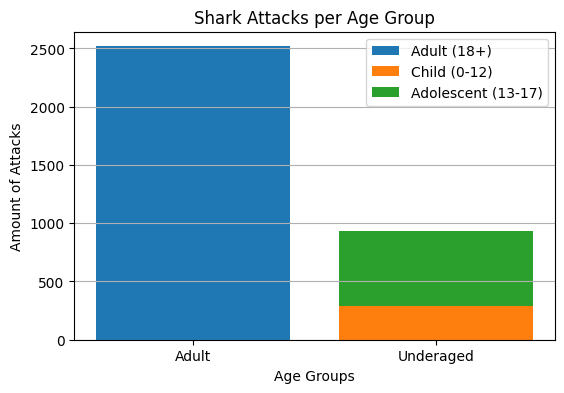

In [ ]:
# Create the figure and the plots
fig, ax = plt.subplots(figsize=(6.2, 4))

# Y-axis
age_group = shark_attacks["Age_group"].value_counts()
adult_count = age_group["adult"]
adolescent_count = age_group["adolescent"]
child_count = age_group["child"]

# Bars where the bar for adolescent_count is placed on top on child_count
ax.bar(0, adult_count, label="Adult (18+)")
ax.bar(1, child_count, label="Child (0-12)")
ax.bar(1, adolescent_count, bottom=child_count, label="Adolescent (13-17)")

# Set cosmetics
ax.set_xticks([0, 1])
ax.set_xticklabels(["Adult", "Underaged"])
ax.set_xlabel("Age Groups")
ax.set_ylabel("Amount of Attacks")
ax.set_title("Shark Attacks per Age Group")
ax.legend()
ax.grid(axis='y')

# Show the plot
plt.show()

# Conclusion: 
No, children are not more like to be attacked by sharks. 
Even when you combine all people under 18 into one group they are still being attacked way less then adults.


---




# Question 3: Are shark attacks where sharks were provoked more or less dangerous?

It is not enough to just look at the absolute counts.
Because since there are more unprovoked than provoked attacks it would not be surprising that there are more fatal outcomes for unprovoked attackss than for provoked attacks.
Therefore it is better to look at the proportions. Or, just as with the shark species: the fatality rate.
What percentage of provoked attacks was fatal and what percentage of unprovoked attacks was fatal?


---



First: compare to see if I can use the group where both the outcome and the type is confirmed

In [ ]:
null_type_count = shark_attacks["Type"].notnull().sum()
null_both_count_2 = (shark_attacks["Type"].notnull() & shark_attacks["Outcome"].notnull()).sum()
difference_2 = null_type_count - null_both_count_2
print(f"The amount of attacks where the type of attack is confirmed is:  {null_type_count}")
print(f"The amount of attacks where both the type and the outcome are confirmed is:  {null_both_count_2}")
print(f"There are {difference_2} attacks where the type is confirmed but the outcome is not ")

The amount of attacks where the type of attack is confirmed is:  5169
The amount of attacks where both the type and the outcome are confirmed is:  5099
There are 70 attacks where the type is confirmed but the outcome is not 


I feel confident I can do that.


---



In [ ]:
# Selecting only the rows where both type and outcome are confirmed: 
question_three_mask = (shark_attacks["Type"].notnull()) & (shark_attacks["Outcome"].notnull())
question_three_df = shark_attacks[question_three_mask]

In [ ]:
# Attack count per type.
total_type = question_three_df["Type"].value_counts()

# Fatal attacks for each type.
fatal_type = question_three_df.loc[question_three_df["Outcome"] == "fatal", "Type"].value_counts()

# Fatality rate per type.
fatality_type = (fatal_type/total_type) * 100

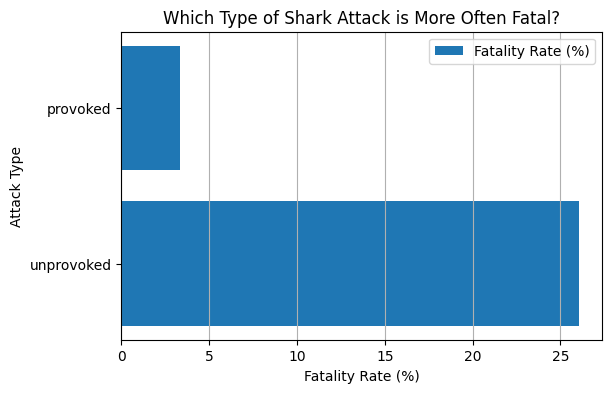

In [ ]:
# Create the figure and the plots
fig, ax = plt.subplots(figsize=(6.2, 4))

# Bars
ax.barh(fatality_type.index, fatality_type, label="Fatality Rate (%)")

# Set cosmetics
ax.set_xlabel("Fatality Rate (%)")
ax.set_ylabel("Attack Type")
ax.set_title("Which Type of Shark Attack is More Often Fatal?")
ax.legend()
ax.grid(axis='x')

# Show the plot
plt.show()

# Conclusion: 
Attacks where the sharks were unprovoked have a higher fatality rate that attacks where the sharks where provoked.

That means that an unprovoked attack could be seen as more dangerous than a provoked attack.

That doesn't come as much as a surprise since one could argue that a provoked attack has more often the purpose of defence, where an unprovoked attack has a higher chance of having a purpose of offence.

# Question 4: Are certain activities more likely to result in a shark attack?
